Author: Bryce Drynan

Date: 2/12/24

In [1]:
#!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3162673 sha256=1f8826bb6ce9c68655143519fc138ca15184f132998d7c25d42c726cd77668fe
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# --
from surprise import Dataset, SVD
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split

from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
import pandas as pd
from surprise import accuracy, BaselineOnly

# Load Data


In [30]:
column_names = ['user_id', 'song_id', 'play_count']
df = pd.read_csv("/content/kaggle_visible_evaluation_triplets.txt", sep='\t', names=column_names)
#df = df.sample(10000)
df.head()


,user_id,song_id,play_count
0,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOBONKR12A58A7A7E0,1
1,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOEGIYH12A6D4FC0E3,1
2,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOFLJQZ12A6D4FADA6,1
3,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOHTKMO12AB01843B0,1
4,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SODQZCY12A6D4F9D11,1


In [31]:
mydf = pd.read_csv("/content/my_songs.csv")
mydf

,user_id,song_id,play_count
0,BryceD,SOWIEYX12D02198892,10
1,BryceD,SOCGALL12A8C133FFC,10
2,BryceD,SOAYZGH12A8AE47427,10
3,BryceD,SORNJMP12A8AE48DA5,10
4,BryceD,SOAWEBZ12CF5828989,10
5,BryceD,SOFIHIL12A6701FFF8,10
6,BryceD,SOKCNWB12AB01813FF,10
7,BryceD,SOSLEWT12A58A7A851,10
8,BryceD,SOIJFJG12A8C132230,10
9,BryceD,SOVXBTV12A8AE4525E,10


In [32]:
df = pd.concat([df,mydf],axis=0)
df.head()

,user_id,song_id,play_count
0,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOBONKR12A58A7A7E0,1
1,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOEGIYH12A6D4FC0E3,1
2,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOFLJQZ12A6D4FADA6,1
3,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOHTKMO12AB01843B0,1
4,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SODQZCY12A6D4F9D11,1


In [33]:
df['play_count'].value_counts().nlargest(10)

1     839136
2     213712
3      95726
5      73542
4      55158
6      31902
7      22317
8      16179
10     15384
9      12227
Name: play_count, dtype: int64

In [34]:
# Define bins and labels
bins = [1, 2, 3, 4, 5,6,7,8,9,10, float('inf')]
labels = [1, 2, 3, 4, 5,6,7,8,9,10]

# Bin the 'play_count' column
df['play_count_binned'] = pd.cut(df['play_count'], bins=bins, labels=labels, right=False)
df['play_count_binned'].value_counts()

1     839136
2     213712
3      95726
10     91049
5      73542
4      55158
6      31902
7      22317
8      16179
9      12227
Name: play_count_binned, dtype: int64

In [35]:
print(f"No. of unique users: {df['user_id'].nunique()}")
print(f"No. of unique songs: {df['song_id'].nunique()}")
print(f"No. of unique play counts: {df['play_count'].nunique()}")

No. of unique users: 110002
No. of unique songs: 163219
No. of unique play counts: 299


In [36]:
df_tracks = pd.read_csv('/content/unique_tracks.txt',
                       sep='<SEP>', names=['track_id','song_id','artist_name','song'], engine='python')
df_tracks.head()

,track_id,song_id,artist_name,song
0,TRMMMYQ128F932D901,SOQMMHC12AB0180CB8,Faster Pussy cat,Silent Night
1,TRMMMKD128F425225D,SOVFVAK12A8C1350D9,Karkkiautomaatti,Tanssi vaan
2,TRMMMRX128F93187D9,SOGTUKN12AB017F4F1,Hudson Mohawke,No One Could Ever
3,TRMMMCH128F425532C,SOBNYVR12A8C13558C,Yerba Brava,Si Vos Querés
4,TRMMMWA128F426B589,SOHSBXH12A8C13B0DF,Der Mystic,Tangle Of Aspens


In [37]:
# Merging triplets.txt and unique_tracks.txt dataset

merged_df = pd.merge(df, df_tracks.drop_duplicates(['song_id']), how='left', on='song_id')
merged_df.head()

,user_id,song_id,play_count,play_count_binned,track_id,artist_name,song
0,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOBONKR12A58A7A7E0,1,1,TRAEHHJ12903CF492F,Dwight Yoakam,You're The One
1,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOEGIYH12A6D4FC0E3,1,1,TRLGMFJ128F4217DBE,Barry Tuckwell/Academy of St Martin-in-the-Fie...,Horn Concerto No. 4 in E flat K495: II. Romanc...
2,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOFLJQZ12A6D4FADA6,1,1,TRTNDNE128F1486812,Cartola,Tive Sim
3,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOHTKMO12AB01843B0,1,1,TRASTUE128F930D488,Lonnie Gordon,Catch You Baby (Steve Pitron & Max Sanna Radio...
4,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SODQZCY12A6D4F9D11,1,1,TRFPLWO128F1486B9E,Miguel Calo,El Cuatrero


# EDA

In [11]:
merged_df.isnull().sum()

user_id              0
song_id              0
play_count           0
play_count_binned    0
track_id             0
artist_name          0
song                 1
dtype: int64

In [12]:
merged_df = merged_df.dropna()

In [13]:
merged_df.shape

(1450947, 7)

Text(0.5, 1.0, 'Histogram for binned play count')

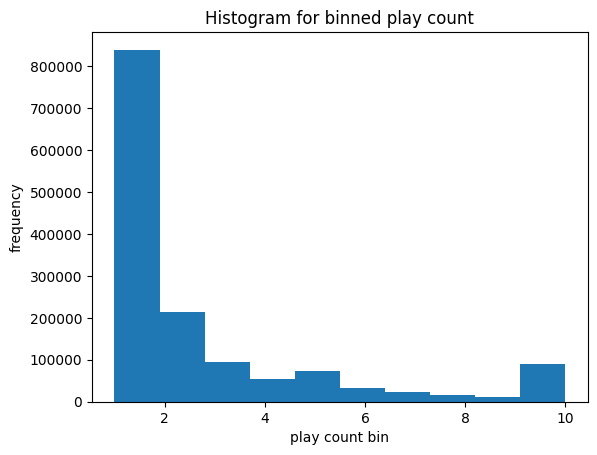

In [14]:
plt.hist( merged_df['play_count_binned'])
plt.xlabel('play count bin')
plt.ylabel('frequency')
plt.title('Histogram for binned play count')

## Most popular Artists

In [15]:
popular = merged_df[['artist_name','song','play_count']]

artist_pop = popular.pivot_table(values=['play_count'],index = 'artist_name' ,aggfunc = 'sum')

artist_pop = artist_pop.sort_values(by='play_count',ascending=False)

artist_pop = artist_pop.reset_index()

artist_pop.rename(columns = {'artist_name':'artist_name', 'play_count':'Total User'}, inplace = True)

artist_pop.head(10)

,artist_name,Total User
0,Kings Of Leon,35857
1,Dwight Yoakam,35688
2,Björk,35210
3,Coldplay,32135
4,Florence + The Machine,28224
5,Justin Bieber,26133
6,Alliance Ethnik,21603
7,Train,21356
8,OneRepublic,20802
9,Harmonia,19461


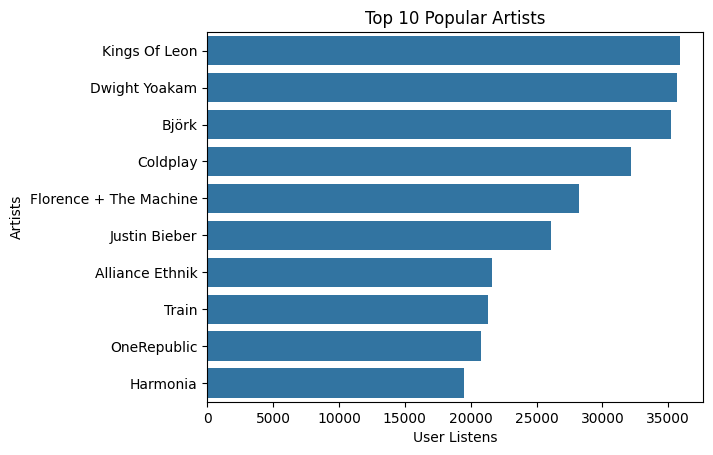

In [16]:
sns.barplot(data = artist_pop.nlargest(10,'Total User'),
        x = 'Total User',
        y = 'artist_name')
plt.xlabel('User Listens')
plt.ylabel('Artists')
plt.title('Top 10 Popular Artists')
plt.show()

## Artist with most songs

In [17]:
most_songs = df_tracks['artist_name'].value_counts().reset_index()
most_songs.columns = ['artist_name','num_of_songs']
most_songs.head(10)

,artist_name,num_of_songs
0,Michael Jackson,194
1,Johnny Cash,193
2,Beastie Boys,187
3,Joan Baez,181
4,Neil Diamond,176
5,Duran Duran,175
6,Radiohead,173
7,Franz Ferdinand,173
8,Aerosmith,173
9,The Rolling Stones,171


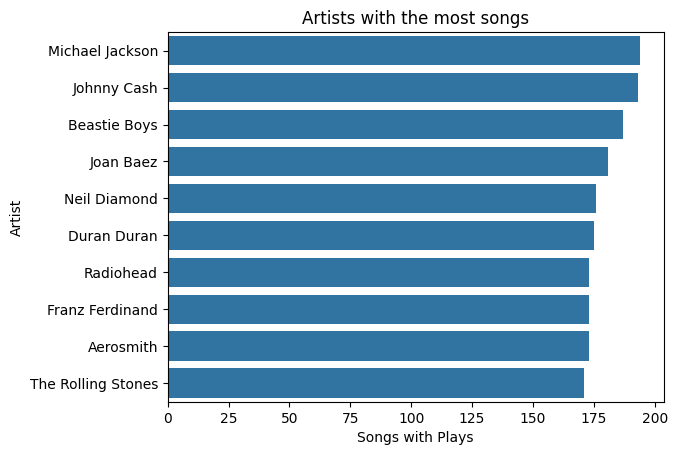

In [18]:
sns.barplot(data = most_songs.nlargest(10, 'num_of_songs'),
           x = 'num_of_songs',
           y = 'artist_name')
plt.xlabel('Songs with Plays')
plt.ylabel('Artist')
plt.title('Artists with the most songs')
plt.show()

## Most Popular Songs

In [19]:
popular = merged_df[['artist_name','song','play_count']]

song_pop = popular.pivot_table(values=['play_count'],index = ['artist_name','song'] ,aggfunc = 'sum')

song_pop = song_pop.sort_values(by='play_count',ascending=False)

song_pop = song_pop.reset_index()

song_pop.head(10)

,artist_name,song,play_count
0,Dwight Yoakam,You're The One,35432
1,Björk,Undo,33179
2,Kings Of Leon,Revelry,24359
3,Harmonia,Sehr kosmisch,19454
4,Barry Tuckwell/Academy of St Martin-in-the-Fie...,Horn Concerto No. 4 in E flat K495: II. Romanc...,17115
5,Florence + The Machine,Dog Days Are Over (Radio Edit),14279
6,OneRepublic,Secrets,12392
7,Sam Cooke,Ain't Misbehavin,11610
8,Tub Ring,Invalid,10794
9,Lonnie Gordon,Catch You Baby (Steve Pitron & Max Sanna Radio...,10515


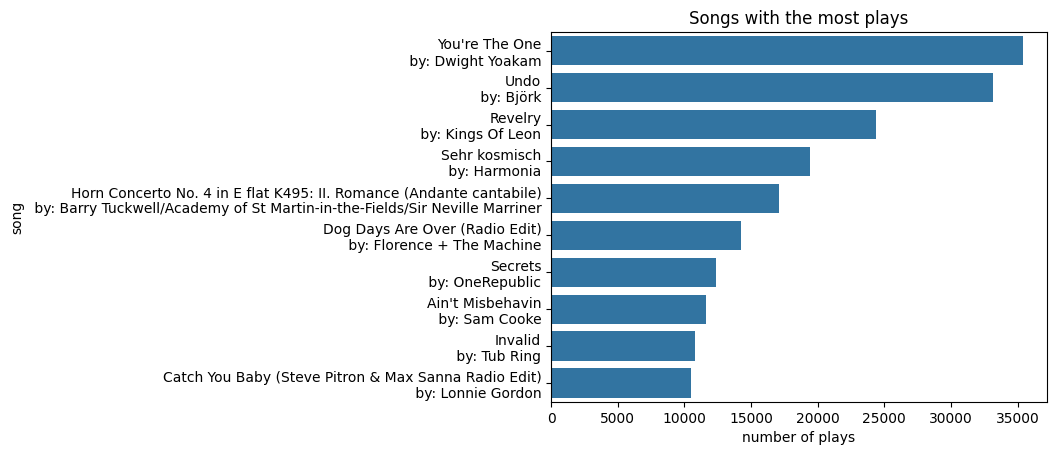

In [20]:
song_pop['title_with_artist'] = song_pop['song'] + '\n by: ' + song_pop['artist_name']
sns.barplot(data = song_pop.nlargest(10, 'play_count'),
           x = 'play_count',
           y = 'title_with_artist')
plt.xlabel('number of plays')
plt.ylabel('song')
plt.title('Songs with the most plays')
plt.show()

## Artists with the Highest avg plays per song

In [21]:
avg_song_play_per_artist = artist_pop.merge(most_songs, how = 'inner',on = 'artist_name')
avg_song_play_per_artist['avg_plays_per_song'] = avg_song_play_per_artist['Total User'] / avg_song_play_per_artist['num_of_songs']
avg_song_play_per_artist = avg_song_play_per_artist.sort_values(by='avg_plays_per_song',ascending=False)
avg_song_play_per_artist = avg_song_play_per_artist[avg_song_play_per_artist['num_of_songs'] >= 5]
avg_song_play_per_artist.head()

,artist_name,Total User,num_of_songs,avg_plays_per_song
5,Justin Bieber,26133,15,1742.200000
45,Charttraxx Karaoke,8395,9,932.777778
14,Barry Tuckwell/Academy of St Martin-in-the-Fie...,17124,19,901.263158
4,Florence + The Machine,28224,32,882.000000
9,Harmonia,19461,24,810.875000


I choose 5 songs as a min because some songs are one off collaborations and I understand this can be skewn by artists with large amount of songs

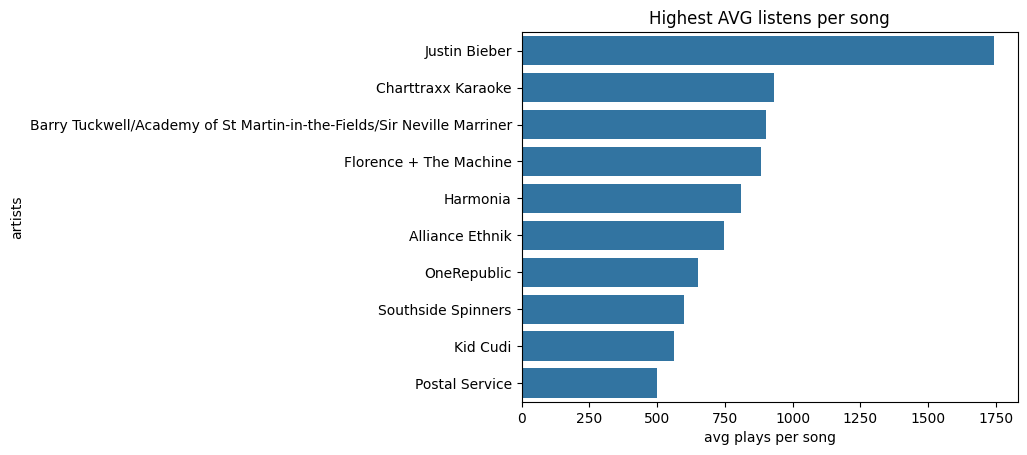

In [22]:
sns.barplot(data = avg_song_play_per_artist.head(10),
           x = 'avg_plays_per_song',
           y = 'artist_name')
plt.xlabel('avg plays per song')
plt.ylabel('artists')
plt.title('Highest AVG listens per song')
plt.show()

# Partition Data

## For Model Fit

In [40]:
# --
reader = Reader(rating_scale=(merged_df['play_count_binned'].min(),
                              merged_df['play_count_binned'].max()))
data = Dataset.load_from_df(merged_df[['user_id','song_id','play_count_binned']], reader)


# test set is made of 30% of the ratings.
trainset, testset = train_test_split(data,test_size=0.3, random_state = 42)

## For Model Train

In [41]:
random_sample = merged_df.sample(frac = .1, random_state = 42)

reader = Reader(rating_scale=(random_sample['play_count_binned'].min(),
                              random_sample['play_count_binned'].max()))
gs_train_data = Dataset.load_from_df(random_sample[['user_id','song_id','play_count_binned']], reader)

# Run Baseline model


In [62]:
# Define and train the BaselineOnly model
print("Evaluating Global Mean Baseline:")
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 5,
               'reg_i': 5}  # You can adjust these parameters
algo_global = BaselineOnly(bsl_options=bsl_options)
algo_global.fit(trainset)
# Predict ratings for the testset
predictions_global = algo_global.test(testset)
# Compute and print RMSE
rmse_global = accuracy.rmse(predictions_global)
# Compute and print MAE
mae_global = accuracy.mae(predictions_global)


Evaluating Global Mean Baseline:
Estimating biases using als...
RMSE: 2.2777
MAE:  1.6124


# Perform Gridsearch to do Hyper Parameter Tuning

In [43]:
from surprise.model_selection import GridSearchCV

param_grid = {
    'n_factors': [25,50,75,100],
    'n_epochs': [10,20, 50],
    'lr_all': [0.01,.02, .03],
    'reg_all': [.02,0.05,.1]
}

gs = GridSearchCV(SVD, param_grid, measures=['RMSE', 'MAE'], cv=3)
gs.fit(gs_train_data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

2.490834192653306
{'n_factors': 100, 'n_epochs': 50, 'lr_all': 0.03, 'reg_all': 0.1}


In [44]:
print(gs.best_score['mae'])
print(gs.best_params['mae'])
print(gs.best_estimator['rmse'])

1.7802597442105819
{'n_factors': 25, 'n_epochs': 50, 'lr_all': 0.03, 'reg_all': 0.1}


In [45]:
results = gs.cv_results
# Convert the dictionary into a Pandas DataFrame
results_df = pd.DataFrame.from_dict(results)

# Filter the DataFrame to show only the relevant columns
relevant_columns = ['param_n_factors', 'param_n_epochs', 'param_lr_all', 'param_reg_all', 'mean_test_rmse', 'mean_test_mae']
results_df = results_df[relevant_columns]

# Print the DataFrame
results_df

,param_n_factors,param_n_epochs,param_lr_all,param_reg_all,mean_test_rmse,mean_test_mae
0,25,10,0.01,0.02,2.498634,1.848399
1,25,10,0.01,0.05,2.497649,1.847208
2,25,10,0.01,0.10,2.497147,1.846588
3,25,10,0.02,0.02,2.499039,1.827570
4,25,10,0.02,0.05,2.497407,1.826188
...,...,...,...,...,...,...
103,100,50,0.02,0.05,2.493842,1.800184
104,100,50,0.02,0.10,2.491739,1.794454
105,100,50,0.03,0.02,2.494778,1.803199
106,100,50,0.03,0.05,2.493792,1.797320


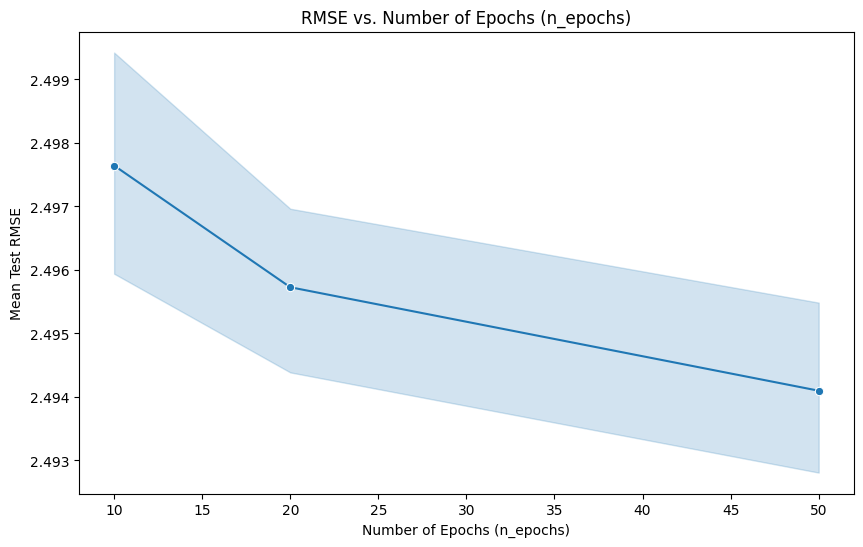

In [46]:
filtered_df = results_df[results_df['param_n_factors'] == 100]  # Example filter

# Creating the line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=filtered_df, x='param_n_epochs', y='mean_test_rmse', marker='o')
plt.title('RMSE vs. Number of Epochs (n_epochs)')
plt.xlabel('Number of Epochs (n_epochs)')
plt.ylabel('Mean Test RMSE')
plt.show()

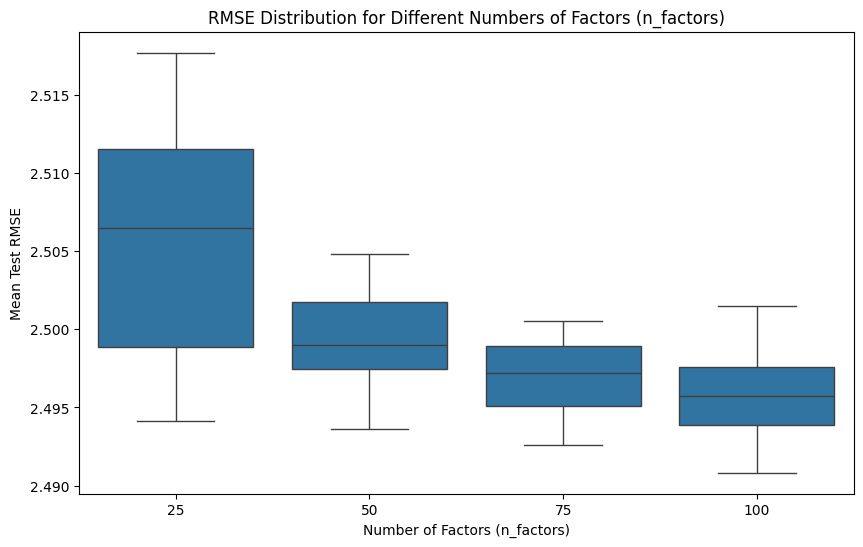

In [47]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=results_df, x='param_n_factors', y='mean_test_rmse')
plt.title('RMSE Distribution for Different Numbers of Factors (n_factors)')
plt.xlabel('Number of Factors (n_factors)')
plt.ylabel('Mean Test RMSE')
plt.show()

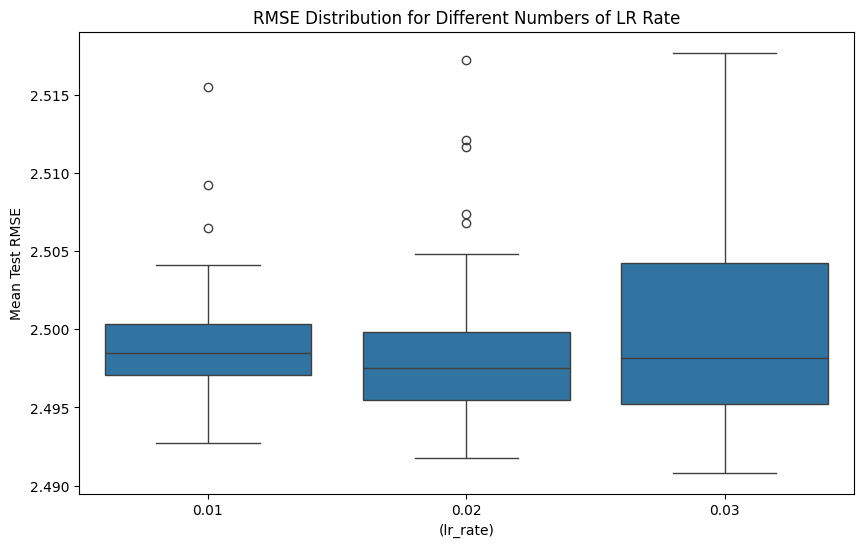

In [48]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=results_df, x='param_lr_all', y='mean_test_rmse')
plt.title('RMSE Distribution for Different Numbers of LR Rate')
plt.xlabel('(lr_rate)')
plt.ylabel('Mean Test RMSE')
plt.show()

In [26]:
#best_params = {'n_factors': 100, 'n_epochs': 50, 'lr_all': 0.03, 'reg_all': 0.1}

In [49]:
best_params = gs.best_params['rmse']
algo = SVD(n_factors=best_params['n_factors'], n_epochs=best_params['n_epochs'], lr_all=best_params['lr_all'], reg_all=best_params['reg_all'])
algo.fit(trainset)

print("Evaluating SVD recomender model:\n")
# make predicitons
test_predictions = algo.test(testset)
# Compute and print RMSE
rmse = accuracy.rmse(test_predictions)

# Compute and print MAE
mae = accuracy.mae(test_predictions)

print("Evaluating SVD:\n")
print(f"RMSE: {rmse:.4f} ")
print(f"MAE: {mae:.4f} ")

Evaluating SVD recomender model:

RMSE: 2.3084
MAE:  1.6122
Evaluating SVD:

RMSE: 2.3084 
MAE: 1.6122 


# Use Optimal Model to get recommendations

In [51]:
def get_top_n_recommendations(user_id, data, model, n=10):
    # 1. Identify all unique songs in the dataset
    all_songs = data.df['song_id'].unique()

    # 2. Filter out songs that the user has already reviewed
    reviewed_songs = data.df[data.df['user_id'] == user_id]['song_id'].unique()
    songs_to_predict = np.setdiff1d(all_songs, reviewed_songs)

    # 3. Use the model to predict the ratings for these songs
    predictions = [model.predict(user_id, song).est for song in songs_to_predict]

    # 4. Combine songs and predictions into a list of tuples and sort them
    song_predictions = list(zip(songs_to_predict, predictions))
    song_predictions.sort(key=lambda x: x[1], reverse=True)

    # Return the top n songs
    return song_predictions[:n]

# Example usage
user_id = 'BryceD'  # replace with the user ID
top_songs = get_top_n_recommendations(user_id, data, algo, n=10)
print(f"Top 10 Song Recommendations for : {user_id}")

for song_name, predicted_rating in top_songs:
    print(f"{song_name}: {predicted_rating:.4f}")

Top 10 Song Recommendations for : BryceD
SOXGUDE12A8C139BC9: 9.5177
SOQVPQA12A8C130127: 9.4501
SOVCMKD12AB017FEC1: 9.4429
SORUNXH12A8C132FF1: 9.3374
SOOTDDD12A8C13AD08: 9.3107
SOCHYQZ12A58A7B030: 9.1549
SOBWMEV12A6D4F4919: 9.0528
SOXKEBM12AF729DBEB: 8.8579
SOUCKRG12AAF3B2C84: 8.8457
SOYOJUC12AB018ED54: 8.8387


In [52]:
pred = pd.DataFrame(top_songs, columns=["song_id", "play_count"])
merged_pred = pd.merge(pred, df_tracks.drop_duplicates(['song_id']), how='left', on='song_id')
merged_pred

,song_id,play_count,track_id,artist_name,song
0,SOXGUDE12A8C139BC9,9.517717,TRDTUVW128F4267A40,Dirty Wormz,Top Of The Food Chain
1,SOQVPQA12A8C130127,9.450053,TRNRMFL128F423FD77,Autopsy,Geek
2,SOVCMKD12AB017FEC1,9.442879,TRREMRZ12903CDCF69,December Wolves,Friday The 13th
3,SORUNXH12A8C132FF1,9.337387,TREGPBB128F423EB4B,Laika,Almost Sleeping
4,SOOTDDD12A8C13AD08,9.310711,TREWNZJ128F4272493,Spook And The Guay,Etre Et Avoir
5,SOCHYQZ12A58A7B030,9.154891,TRXANNF128F92F09A7,Faron Young,I Miss You Already (And You're Not Even Gone)
6,SOBWMEV12A6D4F4919,9.052805,TRHSCDE128F14654B7,Luke Haines,Oliver Twist
7,SOXKEBM12AF729DBEB,8.857892,TRANVCD128F93461F1,Dam Funk,Mirrors
8,SOUCKRG12AAF3B2C84,8.845697,TRUKPJR128F42711DB,Styx,Haven't We Been Here Before?
9,SOYOJUC12AB018ED54,8.838660,TRTANVP12903CCCD50,Blood_ Sweat & Tears,Rosemary


# Get Recommendations for 5 random users

In [56]:
def get_5_with_10_randos():
  df_user = df.groupby(['user_id'])['user_id','play_count'].sum().reset_index()
  df_user.columns = ['user_id', 'plays']
  df_filtered = df_user[df_user['plays'] >= 10]
  return df_filtered['user_id'].sample(n=5, random_state=42).to_list()


In [59]:
def get_rando_songs(data, algo,num_songs):
  randos = get_5_with_10_randos()
  i = 0
  for person in randos:
    top_songs = get_top_n_recommendations(person, data, algo, n=num_songs)
    pred = pd.DataFrame(top_songs, columns=["song_id", "play_count"])
    merged_pred = pd.merge(pred, df_tracks.drop_duplicates(['song_id']), how='left', on='song_id')
    merged_pred.drop(columns = ['track_id', 'song_id'], inplace = True)
    merged_pred['user'] = person
    if i == 0:
      out_df = merged_pred
    else:
      out_df = out_df.append(merged_pred, ignore_index = True)
    i += 1
  return out_df

get_rando_songs(data,algo,5)


<ipython-input-56-3d821498c736>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_user = df.groupby(['user_id'])['user_id','play_count'].sum().reset_index()
<ipython-input-56-3d821498c736>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_user = df.groupby(['user_id'])['user_id','play_count'].sum().reset_index()
<ipython-input-59-e23ee3d17fb4>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  out_df = out_df.append(merged_pred, ignore_index = True)
<ipython-input-59-e23ee3d17fb4>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  out_df = o

,play_count,artist_name,song,user
0,7.269491,Homer/Lisa/Sideshow Mel/Lenny/Krusty/Cameron/Carl,A Star Is Torn Medley,2391fed6d2c7b7edca872ad3132472042a0f192a
1,6.679344,Drive-By Truckers,Outfit,2391fed6d2c7b7edca872ad3132472042a0f192a
2,6.653660,Hombres G,Me siento bien,2391fed6d2c7b7edca872ad3132472042a0f192a
3,6.545690,Atom,Love to Heart (Too Hot),2391fed6d2c7b7edca872ad3132472042a0f192a
4,6.503823,Norma Jean,Entire World Is Counting On Me And They Don't ...,2391fed6d2c7b7edca872ad3132472042a0f192a
5,10.000000,Dam Funk,Mirrors,5c151ab416f10b5ee75de5ae5e459e367c81901a
6,9.396763,Ween,Sorry Charlie,5c151ab416f10b5ee75de5ae5e459e367c81901a
7,9.187289,BLEED THE SKY,Minion,5c151ab416f10b5ee75de5ae5e459e367c81901a
8,9.128091,Grand Theft Audio,Dead Man Leaving,5c151ab416f10b5ee75de5ae5e459e367c81901a
9,9.064613,Promoe,Urban Guerilla Warfare,5c151ab416f10b5ee75de5ae5e459e367c81901a


#Provide a Naive Suggestion to a New User

In [60]:
merged_df.groupby(['song_id','song'])['play_count'].sum().nlargest(5)

song_id             song                                                               
SOBONKR12A58A7A7E0  You're The One                                                         35432
SOAUWYT12A81C206F1  Undo                                                                   33179
SOSXLTC12AF72A7F54  Revelry                                                                24359
SOFRQTD12A81C233C0  Sehr kosmisch                                                          19454
SOEGIYH12A6D4FC0E3  Horn Concerto No. 4 in E flat K495: II. Romance (Andante cantabile)    17115
Name: play_count, dtype: int64

In [61]:
merged_df.groupby(['artist_name'])['play_count'].sum().nlargest(5)

artist_name
Kings Of Leon             35857
Dwight Yoakam             35688
Björk                     35210
Coldplay                  32135
Florence + The Machine    28224
Name: play_count, dtype: int64

# Recommendations for Bryce and Marcus

In [60]:
user_id = 'BryceD'
top_songs = get_top_n_recommendations(user_id, data, algo, n=10)
pred = pd.DataFrame(top_songs, columns=["song_id", "play_count"])
merged_pred = pd.merge(pred, df_tracks.drop_duplicates(['song_id']), how='left', on='song_id')
merged_pred

,song_id,play_count,track_id,artist_name,song
0,SOXGUDE12A8C139BC9,9.517717,TRDTUVW128F4267A40,Dirty Wormz,Top Of The Food Chain
1,SOQVPQA12A8C130127,9.450053,TRNRMFL128F423FD77,Autopsy,Geek
2,SOVCMKD12AB017FEC1,9.442879,TRREMRZ12903CDCF69,December Wolves,Friday The 13th
3,SORUNXH12A8C132FF1,9.337387,TREGPBB128F423EB4B,Laika,Almost Sleeping
4,SOOTDDD12A8C13AD08,9.310711,TREWNZJ128F4272493,Spook And The Guay,Etre Et Avoir
5,SOCHYQZ12A58A7B030,9.154891,TRXANNF128F92F09A7,Faron Young,I Miss You Already (And You're Not Even Gone)
6,SOBWMEV12A6D4F4919,9.052805,TRHSCDE128F14654B7,Luke Haines,Oliver Twist
7,SOXKEBM12AF729DBEB,8.857892,TRANVCD128F93461F1,Dam Funk,Mirrors
8,SOUCKRG12AAF3B2C84,8.845697,TRUKPJR128F42711DB,Styx,Haven't We Been Here Before?
9,SOYOJUC12AB018ED54,8.838660,TRTANVP12903CCCD50,Blood_ Sweat & Tears,Rosemary


In [61]:
user_id = 'MarcusC'
top_songs = get_top_n_recommendations(user_id, data, algo, n=10)
pred = pd.DataFrame(top_songs, columns=["song_id", "play_count"])
merged_pred = pd.merge(pred, df_tracks.drop_duplicates(['song_id']), how='left', on='song_id')
merged_pred

,song_id,play_count,track_id,artist_name,song
0,SOOYVRW12A58A78E69,9.541140,TRJPGDM128F42B7AF9,EPMD,Richter Scale
1,SOUMPJA12AAF3B3FD0,9.439865,TRPBMZK128F93043EB,Buckcherry,Don't Go Away (Live From Rockline) (Explicit)
2,SOWWFXN12AF729D418,9.041034,TROWLKZ128F4252102,Vanessa Carlton,Home
3,SOEYGRA12AF72A095C,8.875593,TRFWWSX12903C9A783,The Sheila Divine,Opportune Moment (Album Version)
4,SODEKFG12A6BD56BC7,8.847208,TRSHJZE128EF34C3CF,Joe Rogan,Boycotting and People Who Like Animals More th...
5,SOQGATX12AB017C8FB,8.805381,TRECYQC128F426A26E,Cypress Hill,Marijuano Locos (Stoned Raiders)
6,SOMRFNF12A6D4FC89C,8.765963,TRTVELS128F14B1233,Susumu Hirasawa,A Drop Filled with Memories
7,SOGXQSQ12AF729F79A,8.757022,TRBFFNE128F92F6001,Zombie Girl,We Are The Ones (Lounge Version)
8,SOCSEYN12A6D4F8178,8.753075,TRACEDP128F145F7BB,Dave Hollister,Tell Me Why
9,SOVGTQL12A6D4FBC64,8.741076,TRKJWEW128F422E577,BLEED THE SKY,Minion
